https://arxiv.org/ftp/arxiv/papers/1305/1305.6143.pdf

In [1]:
import pandas as pd
import pathlib
import shlex
import re
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import csv

from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
def clean_text_for_language_model(text, remove_users=True, remove_urls=True, remove_numbers=True):
    """
    Cleans text for deep learning language models, applies pre tokenization

    :param text: Str, text string

    :return: cleaned string
    """

    re_repetition = re.compile(r'(\S)(\1{3,})') #repetition of multiple non-whitespace characters
    re_word_repetition = re.compile(r'(\b\w+\W+)(\1{3,})') #repetition of multiple words

    s = text
    s = re_repetition.sub(replace_repeated_character, s)
    s = re_word_repetition.sub(replace_repeated_word, s)
    s = lower_and_add_toks_for_case(s)
    s = add_spaces_to_hashtags_and_slashes(s)
    s = remove_multiple_whitespace_from_string(s)
    s = add_start_of_doc_tokens(s)
    s = replace_repeated_punc(s)
    if remove_numbers:
        s = replace_numbers(s)
    if remove_users:
        s = extract_mentioned_users(s,
                                    remove_users=False,
                                    replace_with_token=True,
                                    token_to_replace='[USER]')[0]
    if remove_urls:
        s = extract_urls(s,
                         remove_urls=False,
                         replace_with_token=True,
                         token_to_replace='[URL]')[0]
    return s


def replace_repeated_character(m):
    """
    The expression to sub for repeated letters

    :param m: the match of the regex

    :return: substituted string
    """
    TK_REP = '_tk_rep_char_'
    c, cc = m.groups()
    return f' {TK_REP} {len(cc)+1} {c} '


def replace_repeated_word(m):
    """
    The expression to sub for repeated words

    :param m: the match of the regex

    :return: substituted string
    """
    TK_WREP = '_tk_rep_word_'
    c, cc = m.groups()
    return f' {TK_WREP} {len(cc.split())+1} {c} '


def replace_repeated_punc(s):
    """
    Replace repeated punctuation and newline characters

    :param s: text string

    :return: modified text string
    """
    s = re.sub(r'([^\w\d\s]|\n)(\s\1)+', r'_multi_punc_ \1', s)
    return s


def remove_multiple_whitespace_from_string(s):
    s = re.sub(' {2,}', ' ', s)
    return s


def add_spaces_to_hashtags_and_slashes(s):
    s = re.sub(r'([/#])', r' \1 ', s)
    return s


def add_start_of_doc_tokens(s):
    TOK_DOC, TOK_SEC = '_tk_doc_', '_tk_section_'

    for size, section_start in re.findall(r'\n\s((?:=\s)*=)\s([^=]+)\s\1\s\n', s):
        if size == '=':
            token = TOK_DOC
        else:
            token = TOK_SEC

        s = re.sub(re.escape(size + ' ' + section_start + ' ' + size), token + ' ' + section_start + '.', s)

    return s


def lower_and_add_toks_for_case(s):
    TOK_UP, TOK_SENT, TOK_MIX = ' _tk_up_ ', ' _tk_st_ ', ' _tk_mx_ '
    res = []
    prev = '.'
    re_word = re.compile('\w')
    re_nonsp = re.compile('\S')
    for token in re.findall(r'\w+|\W+', s):
        if token.isupper() and len(token) > 2:
            res += [TOK_UP, token.lower()]
        else:
            res += [token.lower()]
    return ''.join(res)


def replace_numbers(s):
    TOK_NUM = '_number_'

    s = re.sub(r'[0-9]+', TOK_NUM, s)

    return s


def fixup(s):
    re1 = re.compile(r'  +')
    s = s.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(s))


def tokenizer_word(text_string,
                   keep_phrases=False,
                   tokenize_punc=False,
                   split_clitics=False,
                   keep_preceeding_space=False):
    """
    Tokenizer that tokenizes a string of text on spaces and new lines (regardless of however many of each.)

    :param text_string: Python string object to be tokenized.
    :param keep_phrases: Booalean will not split "quoted" text
    :param tokenize_punc: Boolean, if true will tokenize punctuation so "hello," becomes ["hello", ","]
    :param split_clitics: Boolean, if true will split tokens such as "I'm" into [I, 'm], must be tokenizing punctuation

    :return: Array of strings, each is a word
    """

    text_string = str(text_string)

    if keep_phrases:
        tokens = shlex.split(text_string.replace('\n', ' ').replace('/', ' '))
    elif tokenize_punc:
        if split_clitics:
            if keep_preceeding_space:
                tokens = regex.findall(
                    r"(?<!\s)'[\w]*"  # an apostrophe and potentially some other charaters, that come after non-whitespace
                    "|\s?'"  # an apostrophe, preceeded by whitespace
                    "|\s?[\w]+"  # one or more word characters
                    "|\s?[.,!?\-;=\n]"  # any single character of [.,!?\-;=\n]
                    "| \X"
                    "|\X"
                    , text_string, re.UNICODE)
            else:
                tokens = re.findall(r"(?<!\s)'[\w]*|(?<=\s)'|[\w]+|[.,!?\-;=\n]", text_string, re.UNICODE)
        else:
            tokens = re.findall(r"[\w']+|[.,!?\-;=\n]", text_string)
    else:
        tokens = text_string.replace('\n', ' ').replace('/', ' ').split()

    return tokens


def extract_mentioned_users(text_string,
                            remove_users=False,
                            replace_with_token=True,
                            token_to_replace='[USER]'):
    """
    Extracts mentioned_users from a text_string

    :param text_string: String of text you wish to extract mentioned_users from
    :param remove_users: Boolean, if True it will remove the mentioned_users from the text_string
    :param replace_with_token: Boolean, replace the users in the original string with a marker token
    :param token_to_replace: Str, the token to replace the user

    :return: text_sting: Sting as input but with mentioned_users removed if specified
    :return: mentioned_users: List of unique mentioned_users in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    mentioned_users = list(set(re.findall(r"@\w+", text_string)))

    if replace_with_token:
        text_string = re.sub(r"@\w+",
                             token_to_replace,
                             text_string)

    if remove_users and not replace_with_token:
        text_string = re.sub(r"@\w+",
                             '',
                             text_string)

    return text_string, mentioned_users


def extract_urls(text_string,
                 remove_urls=False,
                 replace_with_token=True,
                 token_to_replace='[URL]'):
    """
    Extracts url from a text_string

    :param text_string: String of text you wish to extract url from
    :param remove_urls: Boolean, if True it will remove the url from the text_string
    :param replace_with_token: Boolean, replace the urls in the original string with a marker token
    :param token_to_replace: Str, the token to replace the url

    :return: text_sting: Sting as input but with urls removed if specified
    :return: urls: List of unique urls in the text_string
    """

    if text_string is np.nan:
        text_string = ''

    urls = list(set(re.findall(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                               text_string)))

    if replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             token_to_replace,
                             text_string)

    if remove_urls and not replace_with_token:
        text_string = re.sub(r"(?:http|ftp|https)://[\w_-]+(?:\.[\w_-]+)"
                             r"+(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?",
                             '',
                             text_string)

    return text_string, urls

def negate_sequence_stem(text, stemmer):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    result = stemmer.stem_text(tokens=result)
    return result


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def tokenizer_sentence(text_string):
    """
    Tokenizer that tokenizes a string of text into sentences

    :param text_string: Python string object to be tokenized.
    :return: Array of strings, each is a sentence
    """

    sent_tokenize_list = sent_tokenize(text_string)

    return sent_tokenize_list
    
class Stemmer():

    def __init__(self, language='english'):
        """
        :param language: String representing the language to be used
        """

        self.stemmer = None

        try:
            self.stemmer = SnowballStemmer(language)
        except ValueError as e:
            print(
                'Invalid language supplied to the stemmer, please choose from: ' + " ".join(SnowballStemmer.languages) +
                '\nOr add a new stemmer to the repository ;)')

    def stem_text(self,
                  text_string=None,
                  tokens=None,
                  pos_tuples=False,
                  check_trailing=True,
                  tokens_to_ignore=None):
        """
        Function that stems a text string using the NLTK snowball stemmer

        :param text_string: Python string object to be tokenized and stemmed
        :param tokens: Python list of strings already tokenized
        :param pos_tuples: Bool, if tokens are a list of pos_tuples set this to true
        :param tokens_to_ignore: List of Str, tokens to avoid cleaning

        :return: String comparable to the input but with all words stemmed.
        """

        if not tokens_to_ignore:
            tokens_to_ignore = ["[USER]", "[HASHTAG]", "[URL]"]

        if tokens is None:
            tokens = []
        if text_string is not None:
            tokens = tokenizer_word(text_string,
                                    tokens_to_ignore=tokens_to_ignore)
            tokens = [self.stemmer.stem(token) if token not in tokens_to_ignore else token for token in tokens]
            stemmed = " ".join(tokens)
        else:
            stemmed = [self.stemmer.stem(token) for token in tokens]

        return stemmed
    
def negate_sequence(text):
    """
    Detects negations and transforms negated words into "not_" form.
    """
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokenizer_word(text,
                           keep_phrases=False,
                           tokenize_punc=True,
                           split_clitics=False,
                           keep_preceeding_space=False)
    
    for word in words:
        if negation:
            result.append("not_"+word)
            negation = False
        else:
            result.append(word)
        if any(neg in word for neg in frozenset(["not", "n't", "no"])):
            negation = True
            result = result[:-1]
        if any(c in word for c in delims):
            negation = False
    return result

In [ ]:
tasks = ['amazon_movies', 'amazon_health', 'amazon_books', 'semeval_task_a', 'semeval_task_ce']
sub_tasks = ['fair_balanced_100', 'fair_balanced_300', 'fair_balanced_1000'] #'fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'

stemmer = Stemmer()

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

hyper_map = {'amazon':{'fair_balanced_100':{'c':4, 'f':7}, 'fair_balanced_300':{'c':4, 'f':7}, 'fair_balanced_1000':{'c':64, 'f':8, 'max_gram':3}},
             'semeval':{'fair_balanced_100':{'c':32, 'f':9}, 'fair_balanced_300':{'c':32, 'f':9}, 'fair_balanced_1000':{'c':128, 'f':5}}}

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir.parent
datasets_dir = repo_dir / "datasets"

for task in tasks:
    for subtask in sub_tasks:
        df_trn = pd.read_csv("datasets/"+task+"/"+subtask+"/train.csv")
        df_val = pd.read_csv("datasets/"+task+"/"+subtask+"/validate.csv")
        df_tst = pd.read_csv("datasets/"+task+"/"+subtask+"/test.csv")

        print("Train size:", len(df_trn))
        print("Test size:", len(df_tst))

        c = hyper_map[task.split('_')[0]][subtask]['c']
        f = hyper_map[task.split('_')[0]][subtask]['f']
        max_gram = hyper_map[task.split('_')[0]][subtask].get('max_gram', 1)
        
        df_trn['text'] = df_trn['text'].astype(str)
        df_tst['text'] = df_tst['text'].astype(str)

        df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                      remove_users=True, 
                                                                                      remove_urls=True, 
                                                                                      remove_numbers=True))
        df_tst['text'] = df_tst['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                      remove_users=True, 
                                                                                      remove_urls=True, 
                                                                                      remove_numbers=True))

        tier = int(subtask.split('_')[-1])
        
        cv = CountVectorizer(stop_words=None, 
                             ngram_range=(1,max_gram),
                             max_features=f*tier,
                             tokenizer=lambda e: negate_sequence_stem(e, stemmer),
                             binary=True)

        cv_data_trn = cv.fit_transform(df_trn["text"])
        cv_data_tst = cv.transform(df_tst["text"])

        model = SVC(kernel='rbf', C=c)

        model.fit(cv_data_trn, df_trn['label'])
        
        preds = model.predict(cv_data_tst)
        cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=preds)
        plot_confusion_matrix(cm_test,
                              ['Negative', 'Neutral', 'Positive'],
                              normalize=False,
                              title='Test')
        print("f1 score", f1_score(df_tst["label"], preds, average="micro"))
        
        new_col_name = ".".join(['svm', subtask.split('_')[-1], task])
        for task_tst in tasks:
            subtask_tst = 'fair_balanced_100'
            df_tst = pd.read_csv("datasets/"+task_tst+"/"+subtask_tst+"/test.csv")
            df_tst['text'] = df_tst['text'].astype(str)
            df_tst['text'] = df_tst['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                              remove_users=True, 
                                                                              remove_urls=True, 
                                                                              remove_numbers=True))
            print(task_tst, subtask_tst)

            cv_data_tst = cv.transform(df_tst["text"])
            preds = model.predict(cv_data_tst)

            cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=preds)
            plot_confusion_matrix(cm_test,
                                ['neg', 'neu', 'pos'],
                                normalize=False,
                                title='Validation')
            print("f1 score", f1_score(df_tst["label"], preds, average="micro"))
            print("Accuracy", accuracy_score(df_tst["label"], preds))

            df_tst[new_col_name] = preds

            df_tst.to_csv("datasets/"+task_tst+"/"+subtask_tst+"/test.csv", index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')

['i', 'was', 'hope', 'this', 'not_b', 'over', 'quick']
['not_w', 'all', 'just', 'be', 'friend', '?']
Train size: 300
Test size: 15000


D:\programas_hdd\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Confusion matrix, without normalization
[[   14     0  2096]
 [    2     3  1513]
 [    1     1 11370]]


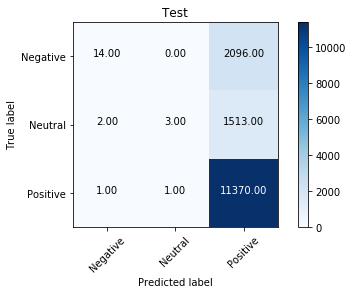

f1 score 0.7591333333333333
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[    0     0  2110]
 [    0     0  1518]
 [    0     0 11372]]


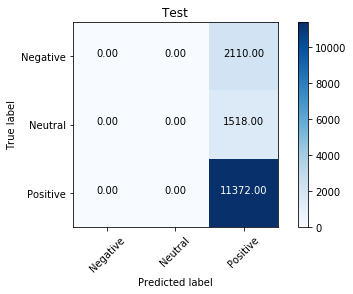

f1 score 0.7581333333333333
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[  786   113  1211]
 [  193   197  1128]
 [  270   219 10883]]


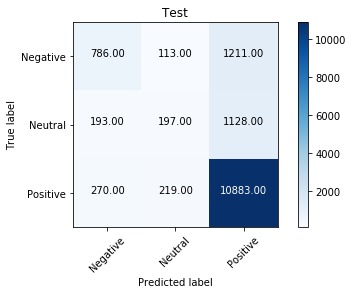

f1 score 0.7910666666666667
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[    0     0  1540]
 [    0     0  1410]
 [    0     0 12050]]


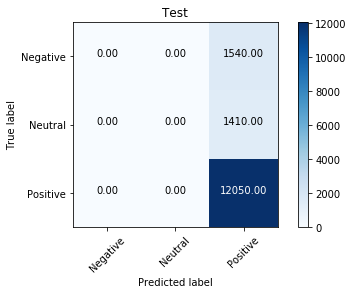

f1 score 0.8033333333333333
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[    0     0  1540]
 [    0     0  1410]
 [    0     0 12050]]


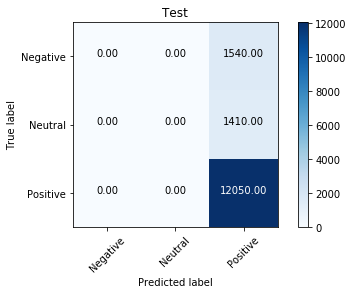

f1 score 0.8033333333333333
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[  254    48  1238]
 [   78    46  1286]
 [   69   117 11864]]


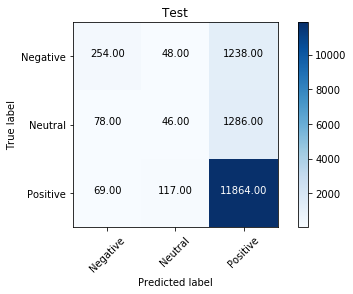

f1 score 0.8109333333333333
Train size: 300
Test size: 15000
Confusion matrix, without normalization
[[    0     0  1555]
 [    0     0  1689]
 [    0     0 11756]]


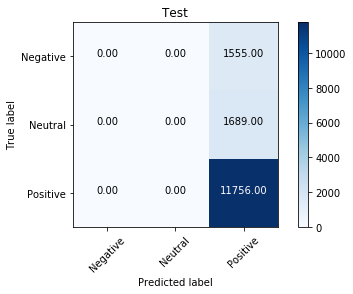

f1 score 0.7837333333333333
Train size: 900
Test size: 15000
Confusion matrix, without normalization
[[    0     0  1555]
 [    0     0  1689]
 [    0     0 11756]]


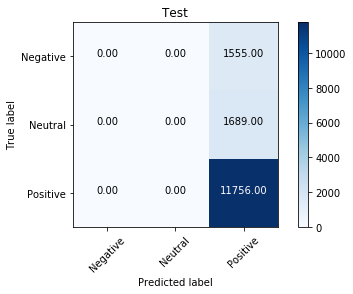

f1 score 0.7837333333333333
Train size: 3000
Test size: 15000
Confusion matrix, without normalization
[[  424   138   993]
 [  168   231  1290]
 [  163   229 11364]]


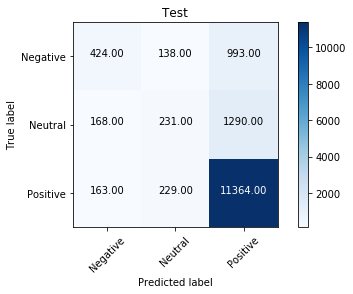

f1 score 0.8012666666666667
Train size: 300
Test size: 29632
Confusion matrix, without normalization
[[  84 2897 1363]
 [ 113 9564 3717]
 [ 127 5693 6074]]


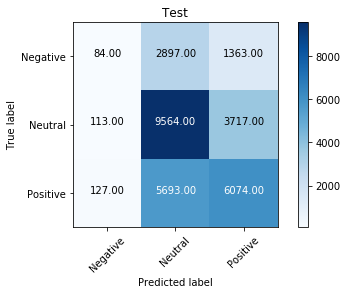

f1 score 0.5305750539956804
Train size: 900
Test size: 29632
Confusion matrix, without normalization
[[    0  3227  1117]
 [    0 10686  2708]
 [    0  5842  6052]]


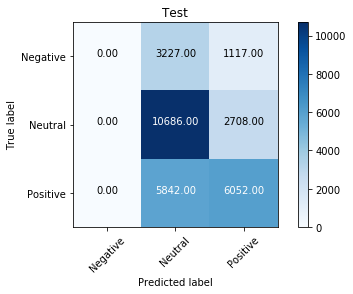

f1 score 0.5648623110151187
Train size: 3000
Test size: 29632
Confusion matrix, without normalization
[[  304  3137   903]
 [  189 10523  2682]
 [   91  4928  6875]]


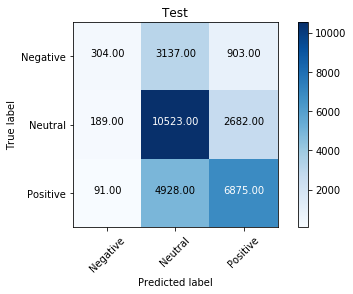

f1 score 0.5973947084233261
Train size: 300
Test size: 8763
Confusion matrix, without normalization
[[   4  500  669]
 [   1 1548 2027]
 [   6 1186 2822]]


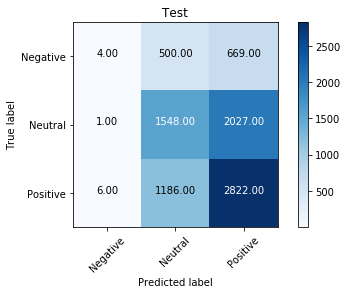

f1 score 0.49914412872304004
Train size: 900
Test size: 8763
Confusion matrix, without normalization
[[   0  770  403]
 [   0 2200 1376]
 [   0 1563 2451]]


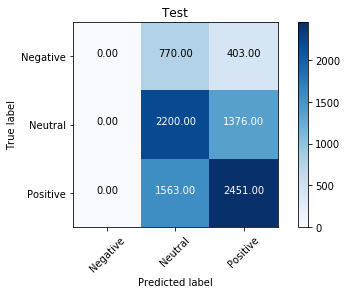

f1 score 0.5307543078854273
Train size: 3000
Test size: 8763
Confusion matrix, without normalization
[[   9  747  417]
 [   7 2213 1356]
 [   5 1282 2727]]


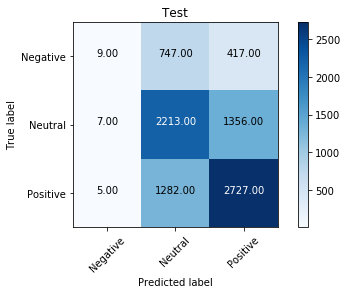

f1 score 0.5647609266233026


In [3]:
tasks = ['amazon_movies', 'amazon_health', 'amazon_books', 'semeval_task_a', 'semeval_task_ce']
sub_tasks = ['fair_unbalanced_100', 'fair_unbalanced_300', 'fair_unbalanced_1000'] 

stemmer = Stemmer()

print(negate_sequence_stem("i was hoping this wouldn't be over quickly", stemmer))
print(negate_sequence_stem("can't we all just be friends?", stemmer))

hyper_map = {'amazon':{'fair_unbalanced_100':{'c':4, 'f':7}, 'fair_unbalanced_300':{'c':4, 'f':7}, 'fair_unbalanced_1000':{'c':64, 'f':8, 'max_gram':3}},
             'semeval':{'fair_unbalanced_100':{'c':32, 'f':9}, 'fair_unbalanced_300':{'c':32, 'f':9}, 'fair_unbalanced_1000':{'c':128, 'f':5}}}

notebook_dir = pathlib.Path.cwd()
repo_dir = notebook_dir.parent
datasets_dir = repo_dir / "datasets"

for task in tasks:
    for subtask in sub_tasks:
        df_trn = pd.read_csv("datasets/"+task+"/"+subtask+"/train.csv")
        df_val = pd.read_csv("datasets/"+task+"/"+subtask+"/validate.csv")
        df_tst = pd.read_csv("datasets/"+task+"/fair_unbalanced_100/test.csv")

        print("Train size:", len(df_trn))
        print("Test size:", len(df_tst))

        c = hyper_map[task.split('_')[0]][subtask]['c']
        f = hyper_map[task.split('_')[0]][subtask]['f']
        max_gram = hyper_map[task.split('_')[0]][subtask].get('max_gram', 1)
        
        df_trn['text'] = df_trn['text'].astype(str)
        df_tst['text'] = df_tst['text'].astype(str)

        df_trn['text'] = df_trn['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                      remove_users=True, 
                                                                                      remove_urls=True, 
                                                                                      remove_numbers=True))
        df_tst['text'] = df_tst['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                                      remove_users=True, 
                                                                                      remove_urls=True, 
                                                                                      remove_numbers=True))

        tier = int(subtask.split('_')[-1])
        
        cv = CountVectorizer(stop_words=None, 
                             ngram_range=(1,max_gram),
                             max_features=f*tier,
                             tokenizer=lambda e: negate_sequence_stem(e, stemmer),
                             binary=True)

        cv_data_trn = cv.fit_transform(df_trn["text"])
        cv_data_tst = cv.transform(df_tst["text"])

        model = SVC(kernel='rbf', C=c)

        model.fit(cv_data_trn, df_trn['label'])
        
        preds = model.predict(cv_data_tst)
        cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=preds)
        plot_confusion_matrix(cm_test,
                              ['Negative', 'Neutral', 'Positive'],
                              normalize=False,
                              title='Test')
        print("f1 score", f1_score(df_tst["label"], preds, average="micro"))
        
        new_col_name = ".".join(['svm', subtask.split('_')[-1], task])
        df_tst[new_col_name] = preds

        df_tst.to_csv("datasets/"+task+"/fair_unbalanced_100/test.csv", index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')

In [ ]:
subtask_tst = 'fair_balanced_100'
df_tst = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/semeval_task_a/"+subtask_tst+"/test.csv")
df_tst['text'] = df_tst['text'].astype(str)
df_tst['text'] = df_tst['text'].apply(lambda e: clean_text_for_language_model(e, 
                                                                  remove_users=True, 
                                                                  remove_urls=True, 
                                                                  remove_numbers=True))

In [ ]:
df_tst = pd.read_csv("datasets/amazon_movies/fair_balanced_100/test.csv")

In [ ]:
df_tst.columns.tolist()